In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading in full data set
# brfss_total = pd.read_csv("../csv_data/brfss_total.csv")
brfss_total = pd.read_csv("./brfss_total.csv")

In [5]:
brfss_total.head()

,Unnamed: 0,_STATE,DISPCODE,PHYSHLTH,MENTHLTH,USENOW3,HISPANC2,MARITAL,CHILDREN,EMPLOY,RENTHOM1,SEX,QLACTLM2,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
0,0,5.0,110.0,0.0,0.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,53.0,1.0,4.0,1.0,3.0,5.0,1.0
1,1,5.0,110.0,15.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,64.0,2.0,3.0,1.0,2.0,2.0,1.0
2,2,5.0,110.0,6.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,58.0,1.0,4.0,1.0,3.0,2.0,1.0
3,3,5.0,110.0,30.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,76.0,2.0,4.0,1.0,1.0,0.0,2.0
4,4,5.0,110.0,13.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,82.0,2.0,3.0,1.0,2.0,0.0,2.0


In [6]:
# just making sure no nulls are present
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117555 entries, 0 to 117554
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  117555 non-null  int64  
 1   _STATE      117555 non-null  float64
 2   DISPCODE    117555 non-null  float64
 3   PHYSHLTH    117555 non-null  float64
 4   MENTHLTH    117555 non-null  float64
 5   USENOW3     117555 non-null  float64
 6   HISPANC2    117555 non-null  float64
 7   MARITAL     117555 non-null  float64
 8   CHILDREN    117555 non-null  float64
 9   EMPLOY      117555 non-null  float64
 10  RENTHOM1    117555 non-null  float64
 11  SEX         117555 non-null  float64
 12  QLACTLM2    117555 non-null  float64
 13  ACEDEPRS    117555 non-null  float64
 14  ACEDRINK    117555 non-null  float64
 15  ACEDRUGS    117555 non-null  float64
 16  ACEPRISN    117555 non-null  float64
 17  ACEDIVRC    117555 non-null  float64
 18  ACEPUNCH    117555 non-null  float64
 19  AC

In [7]:
brfss_total.drop(columns=['Unnamed: 0'], inplace=True)

Will put this information in my README for simplicity, instead of every notebook

---


**Variables I will try to predict with my models:**
- USENOW3: Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
    - classification
    - 0 = Don't know, Not sure or Refused, 1 = every day, 2 = some days, 3 = not at all
- QLACTLM2: Are you limited in any way in any activities because of physical, mental, or emotional problems?
    - classification
    - 0 = Don't know, Not sure or Refused, 1 = yes, 2 = no
- _RFHLTH: Adults with good or better health vs. fair or poor health
    - classification
    - based off of GENHLTH
    - 0 = Don't know, Not sure or Refused, 1 = Good or Better Health, 2 = Fair or Poor Health
- _SMOKER3: Four-level smoker status: Everyday smoker, Someday smoker, Former smoker, Non-smoker
    - classification
    - based off of SMOKE100 & SMOKEDAY
    - 0 = Don't know, Not sure or Refused, 1 = Current smoker (now smokes every day), 2 = Current smoker (now smokes some days), 3 = Former smoker, 4 = Never smoked
 
 
**Will use get dummies to dummify ordinal/nominal features**

**Will use SMOTE to compensensate for imbalanced classes**

**Will aggregate all ACEs into two groups: Abuse and Household Challenges**

In [8]:
np.random.seed(151)

In [9]:
# creating X variable with all features
X_all = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [10]:
# creating the 4 y's
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [11]:
#original baseline for tobacco
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [12]:
#original baseline for activity
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [13]:
#original baseline for health
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [14]:
#original baseline for smoker
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [15]:
# splitting X up so I can do some engineering on the nominal data and ACE columns
X_num = X_all[['PHYSHLTH', 'MENTHLTH', 'CHILDREN']]
X_cat = X_all[['_STATE', 'DISPCODE', 'HISPANC2', 'MARITAL', 'EMPLOY', 'RENTHOM1', 'SEX', 'MSCODE', 
               '_IMPAGE', '_PRACE', '_EDUCAG', '_INCOMG','_TOTINDA']]
ace = X_all[['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [16]:
# updating ACE columns to be a count depending on the question
# first 5 questions are yes or no, so yes will be be counted as 1 and no will be counted as 0
# last 6 are questions of frequency, never = 0, once = 1, more than once = 2 (since not given an exact number)
ace['ACEDEPRS'] = ace['ACEDEPRS'].map({1:1, 2:0, 0:0})
ace['ACEDRINK'] = ace['ACEDRINK'].map({1:1, 2:0, 0:0})
ace['ACEDRUGS'] = ace['ACEDRUGS'].map({1:1, 2:0, 0:0})
ace['ACEPRISN'] = ace['ACEPRISN'].map({1:1, 2:0, 0:0})
ace['ACEDIVRC'] = ace['ACEDIVRC'].map({1:1, 2:0, 0:0})
ace['ACEPUNCH'] = ace['ACEPUNCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHURT'] = ace['ACEHURT'].map({1:0, 2:1, 3:2, 0:0})
ace['ACESWEAR'] = ace['ACESWEAR'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETOUCH'] = ace['ACETOUCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETTHEM'] = ace['ACETTHEM'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHVSEX'] = ace['ACEHVSEX'].map({1:0, 2:1, 3:2, 0:0})

In [17]:
X_num['ACE_Count'] = ace.sum(axis = 1)

In [18]:
X_cat = X_cat.astype(str)

In [19]:
# dummifying nominal variables for X_all
X_dummies = pd.get_dummies(X_cat, drop_first=True)
X_dummies.head()

,_STATE_15.0,_STATE_19.0,_STATE_22.0,_STATE_27.0,_STATE_30.0,_STATE_32.0,_STATE_37.0,_STATE_40.0,_STATE_47.0,_STATE_5.0,_STATE_50.0,_STATE_53.0,_STATE_55.0,DISPCODE_1100.0,DISPCODE_120.0,DISPCODE_1200.0,HISPANC2_1.0,HISPANC2_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,EMPLOY_1.0,EMPLOY_2.0,EMPLOY_3.0,EMPLOY_4.0,EMPLOY_5.0,EMPLOY_6.0,RENTHOM1_1.0,RENTHOM1_2.0,RENTHOM1_3.0,SEX_2.0,MSCODE_1.0,MSCODE_2.0,MSCODE_3.0,MSCODE_5.0,_IMPAGE_18.0,_IMPAGE_19.0,...,_IMPAGE_74.0,_IMPAGE_75.0,_IMPAGE_76.0,_IMPAGE_78.0,_IMPAGE_79.0,_IMPAGE_80.0,_IMPAGE_81.0,_IMPAGE_82.0,_IMPAGE_83.0,_IMPAGE_84.0,_IMPAGE_85.0,_IMPAGE_86.0,_IMPAGE_87.0,_IMPAGE_89.0,_IMPAGE_90.0,_IMPAGE_91.0,_IMPAGE_92.0,_IMPAGE_93.0,_IMPAGE_94.0,_IMPAGE_95.0,_IMPAGE_96.0,_IMPAGE_97.0,_IMPAGE_98.0,_PRACE_1.0,_PRACE_2.0,_PRACE_3.0,_PRACE_4.0,_PRACE_5.0,_PRACE_6.0,_EDUCAG_1.0,_EDUCAG_2.0,_EDUCAG_3.0,_EDUCAG_4.0,_INCOMG_1.0,_INCOMG_2.0,_INCOMG_3.0,_INCOMG_4.0,_INCOMG_5.0,_TOTINDA_1.0,_TOTINDA_2.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [20]:
X_num.head()

,PHYSHLTH,MENTHLTH,CHILDREN,ACE_Count
0,0.0,0.0,1.0,0.0
1,15.0,0.0,0.0,3.0
2,6.0,0.0,0.0,0.0
3,30.0,0.0,0.0,0.0
4,13.0,0.0,0.0,0.0


In [21]:
# merging numerical and nominal data into one data frame
X_all = X_num.merge(X_dummies, left_index=True, right_index=True)

In [22]:
X_all.shape

(117555, 138)

In [23]:
type(X_all)

pandas.core.frame.DataFrame

In [24]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X_all1, y_tobacco = sm.fit_resample(X_all, y_tobacco)

sm2 = SMOTE(random_state=151)
X_all2, y_activity = sm2.fit_resample(X_all, y_activity)

sm3 = SMOTE(random_state=151)
X_all3, y_health = sm3.fit_resample(X_all, y_health)

sm4 = SMOTE(random_state=151)
X_all4, y_smoker = sm4.fit_resample(X_all, y_smoker)

In [ ]:
y_tobacco.value_counts(normalize=True)

In [ ]:
y_activity.value_counts(normalize=True)

In [ ]:
y_health.value_counts(normalize=True)

In [ ]:
y_smoker.value_counts(normalize=True)

In [26]:
# looks like with SMOTE resampling, data set has increased about 4x
X_all1.shape

(454496, 138)

In [27]:
type(X_all1)

numpy.ndarray

In [28]:
# creating training and testing sets for all y's
X_train_all, X_test_all, y_train_tobacco, y_test_tobacco = train_test_split(X_all1, y_tobacco, random_state = 151, stratify=y_tobacco)
X_train_all2, X_test_all2, y_train_activity, y_test_activity = train_test_split(X_all2, y_activity, random_state = 151, stratify=y_activity)
X_train_all3, X_test_all3, y_train_health, y_test_health = train_test_split(X_all3, y_health, random_state = 151, stratify=y_health)
X_train_all4, X_test_all4, y_train_smoker, y_test_smoker = train_test_split(X_all4, y_smoker, random_state = 151, stratify=y_smoker)

In [29]:
X_train_all.shape

(340872, 138)

In [31]:
y_train_tobacco.shape

(340872,)

In [32]:
pipe_all_tobacco = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300))
pipe_all_tobacco.fit(X_train_all, y_train_tobacco)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [33]:
pipe_all_activity = make_pipeline(SelectKBest(f_classif, k=136), StandardScaler(), ExtraTreesClassifier(max_depth=None, n_estimators=500))
pipe_all_activity.fit(X_train_all2, y_train_activity)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=136,
                             score_func=<function f_classif at 0x7fb3cf16e9d8>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=None,
                                   

In [34]:
pipe_all_health = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=100))
pipe_all_health.fit(X_train_all3, y_train_health)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fb3cf16e9d8>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                

In [35]:
pipe_all_smoker = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=500))
pipe_all_smoker.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fb3cf16e9d8>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                

In [36]:
pipe_all_smoker_lr = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), LogisticRegression(C=0.5))
pipe_all_smoker_lr.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fb3cf16e9d8>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [37]:
# getting predicting for each y's model
tobacco_all_preds = pipe_all_tobacco.predict(X_test_all)
activity_all_preds = pipe_all_activity.predict(X_test_all2)
health_all_preds = pipe_all_health.predict(X_test_all3)
smoker_all_preds = pipe_all_smoker.predict(X_test_all4)

# calculating the precision score for each y's model
tobacco_all_prec = precision_score(y_test_tobacco, tobacco_all_preds, average='micro')
activity_all_prec = precision_score(y_test_activity, activity_all_preds, average='micro')
health_all_prec = precision_score(y_test_health, health_all_preds, average='micro')
smoker_all_prec = precision_score(y_test_smoker, smoker_all_preds, average='micro')

In [38]:
print(f' training accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_train_all, y_train_tobacco)}')
print(f' training accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_train_all2, y_train_activity)}')
print(f' training accuracy for health w/ACE grouped: {pipe_all_health.score(X_train_all3, y_train_health)}')
print(f' training accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_train_all4, y_train_smoker)}')

 training accuracy for tobacco w/ACE grouped: 0.9965441573376517
 training accuracy for activity w/ACE grouped: 0.9990398363547178
 training accuracy for health w/ACE grouped: 0.9987981326972872
 training accuracy for smoker w/ACE grouped: 0.9935369667236422


In [39]:
print(f' testing accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_test_all, y_test_tobacco)}')
print(f' testing accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_test_all2, y_test_activity)}')
print(f' testing accuracy for health w/ACE grouped: {pipe_all_health.score(X_test_all3, y_test_health)}')
print(f' testing accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_test_all4, y_test_smoker)}')

 testing accuracy for tobacco w/ACE grouped: 0.9920967401253257
 testing accuracy for activity w/ACE grouped: 0.9155591039308693
 testing accuracy for health w/ACE grouped: 0.9453454540392299
 testing accuracy for smoker w/ACE grouped: 0.8006967459095535


In [40]:
print(f'Precision for tobacco w/ACE grouped: {tobacco_all_prec}')
print(f'Precision for activity w/ACE grouped: {activity_all_prec}')
print(f'Precision for health w/ACE grouped: {health_all_prec}')
print(f'Precision for smoker w/ACE grouped: {smoker_all_prec}')

Precision for tobacco w/ACE grouped: 0.9920967401253257
Precision for activity w/ACE grouped: 0.9155591039308693
Precision for health w/ACE grouped: 0.9453454540392299
Precision for smoker w/ACE grouped: 0.8006967459095535


In [42]:
# getting features importances for smokeless tobacco use
tobacco_all = pd.DataFrame({'features': X_all.columns.values, 'importance':pipe_all_tobacco.named_steps['randomforestclassifier'].feature_importances_})
tobacco_all = tobacco_all.sort_values('importance', ascending = False)
tobacco_all.head(10)

,features,importance
12,_STATE_47.0,0.105485
37,SEX_2.0,0.083121
3,ACE_Count,0.056033
17,DISPCODE_1100.0,0.049042
34,RENTHOM1_1.0,0.032145
28,EMPLOY_1.0,0.026223
38,MSCODE_1.0,0.022191
2,CHILDREN,0.020242
135,_INCOMG_5.0,0.019619
130,_EDUCAG_4.0,0.019582


In [43]:
tobacco_all.tail(10)

,features,importance
107,_IMPAGE_84.0,4.134442e-04
111,_IMPAGE_89.0,3.427955e-04
109,_IMPAGE_86.0,2.584162e-04
114,_IMPAGE_92.0,1.442131e-04
115,_IMPAGE_93.0,1.324313e-04
117,_IMPAGE_95.0,4.619060e-05
116,_IMPAGE_94.0,2.273391e-06
120,_IMPAGE_98.0,1.983613e-06
118,_IMPAGE_96.0,1.174570e-06
119,_IMPAGE_97.0,8.927631e-07


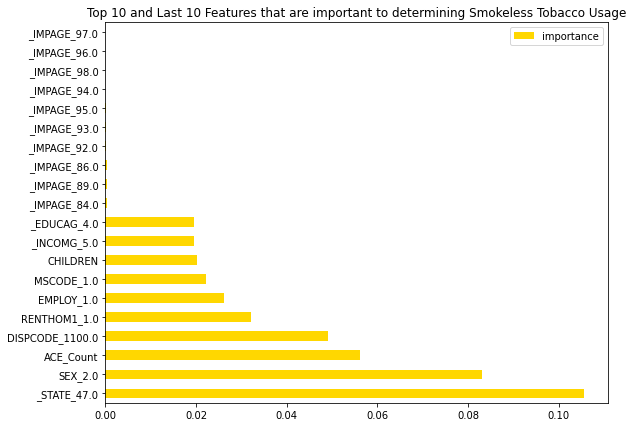

In [102]:
def top_bottom(df, color):
  ''' Function to map Top 10 and Last 10 Features based on importance'''
  top_bottom = pd.merge(df.head(10), df.tail(10), how='outer')
  top_bottom.plot(kind='barh', figsize=(9, 7), color=color)
  plt.yticks(ticks=top_bottom.index, labels=top_bottom.features)
  plt.legend();
  return

top_bottom(tobacco_all, color = 'gold')
plt.title('Top 10 and Last 10 Features that are important to determining Smokeless Tobacco Usage');

In [82]:
# getting features selected by 'selectkbest' for other three y's
features_activity_all = pipe_all_activity.named_steps['selectkbest'].get_support(indices=True) 
features_health_all = pipe_all_health.named_steps['selectkbest'].get_support(indices=True) 
features_smoker_all = pipe_all_smoker.named_steps['selectkbest'].get_support(indices=True) 

In [83]:
# getting column names for features selected by 'selectkbest' for other three y's
X_cols_activity_all = X_all.columns.values[features_activity_all]
X_cols_health_all = X_all.columns.values[features_health_all]
X_cols_smoker_all = X_all.columns.values[features_smoker_all]

In [84]:
# getting each feature's importance for other three y's
coefs_activity_all = pipe_all_activity.named_steps['extratreesclassifier'].feature_importances_
coefs_health_all = pipe_all_health.named_steps['randomforestclassifier'].feature_importances_
coefs_smoker_all = pipe_all_smoker.named_steps['randomforestclassifier'].feature_importances_

In [89]:
# feature importances for activity limitations
activity_all = pd.DataFrame({'features': X_cols_activity_all, 'importance':coefs_activity_all})
activity_all = activity_all.sort_values('importance', ascending = False)
activity_all.head(10)

,features,importance
0,PHYSHLTH,0.064875
12,_STATE_47.0,0.044570
28,EMPLOY_1.0,0.043460
3,ACE_Count,0.035963
34,RENTHOM1_1.0,0.032924
133,_INCOMG_5.0,0.029446
1,MENTHLTH,0.027759
37,SEX_2.0,0.024443
17,DISPCODE_1100.0,0.022504
22,MARITAL_1.0,0.020054


In [90]:
activity_all.tail(10)

,features,importance
47,_IMPAGE_23.0,0.000704
49,_IMPAGE_25.0,0.000692
42,_IMPAGE_18.0,0.000667
44,_IMPAGE_20.0,0.000644
43,_IMPAGE_19.0,0.000639
19,DISPCODE_1200.0,0.000567
116,_IMPAGE_95.0,0.000546
118,_IMPAGE_98.0,0.000274
115,_IMPAGE_94.0,0.000169
117,_IMPAGE_96.0,0.000088


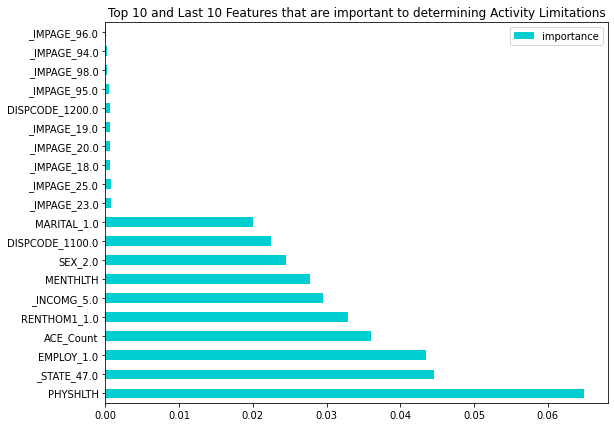

In [103]:
top_bottom(activity_all, color='darkturquoise')
plt.title('Top 10 and Last 10 Features that are important to determining Activity Limitations');

In [92]:
# feature importances for self-reported health
health_all = pd.DataFrame({'features': X_cols_health_all, 'importance':coefs_health_all})
health_all = health_all.sort_values('importance', ascending = False)
health_all.head(10)

,features,importance
0,PHYSHLTH,0.097954
25,EMPLOY_1.0,0.047515
3,ACE_Count,0.041742
103,_INCOMG_5.0,0.038762
1,MENTHLTH,0.036171
99,_EDUCAG_4.0,0.029424
33,SEX_2.0,0.028227
30,RENTHOM1_1.0,0.027995
105,_TOTINDA_2.0,0.027984
104,_TOTINDA_1.0,0.025009


In [94]:
health_all.tail(10)

,features,importance
93,_PRACE_4.0,0.000676
43,_IMPAGE_27.0,0.000651
86,_IMPAGE_90.0,0.000595
47,_IMPAGE_31.0,0.000566
39,_IMPAGE_21.0,0.000528
42,_IMPAGE_24.0,0.000487
46,_IMPAGE_30.0,0.000465
38,_IMPAGE_20.0,0.000324
40,_IMPAGE_22.0,0.000321
37,_IMPAGE_18.0,0.000303


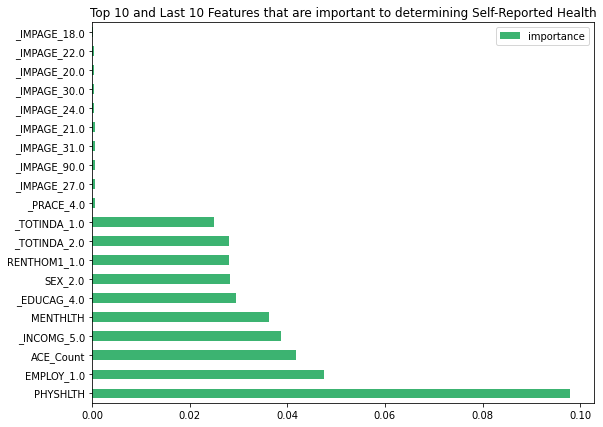

In [104]:
top_bottom(health_all, color = 'mediumseagreen')
plt.title('Top 10 and Last 10 Features that are important to determining Self-Reported Health');

In [96]:
# feature importances for smoker status
smoker_all = pd.DataFrame({'features': X_cols_smoker_all, 'importance':coefs_smoker_all})
smoker_all = smoker_all.sort_values('importance', ascending = False)
smoker_all.head(10)

,features,importance
3,ACE_Count,0.070039
0,PHYSHLTH,0.039284
1,MENTHLTH,0.036018
11,_STATE_47.0,0.035014
33,SEX_2.0,0.031330
2,CHILDREN,0.028582
24,EMPLOY_1.0,0.027787
30,RENTHOM1_1.0,0.026616
36,MSCODE_5.0,0.023771
15,DISPCODE_1100.0,0.023718


In [97]:
smoker_all.tail(10)

,features,importance
44,_IMPAGE_25.0,0.001402
86,_IMPAGE_87.0,0.001280
39,_IMPAGE_20.0,0.001140
40,_IMPAGE_21.0,0.001119
38,_IMPAGE_19.0,0.001086
85,_IMPAGE_86.0,0.001064
87,_IMPAGE_90.0,0.000975
37,_IMPAGE_18.0,0.000905
89,_IMPAGE_92.0,0.000902
88,_IMPAGE_91.0,0.000483


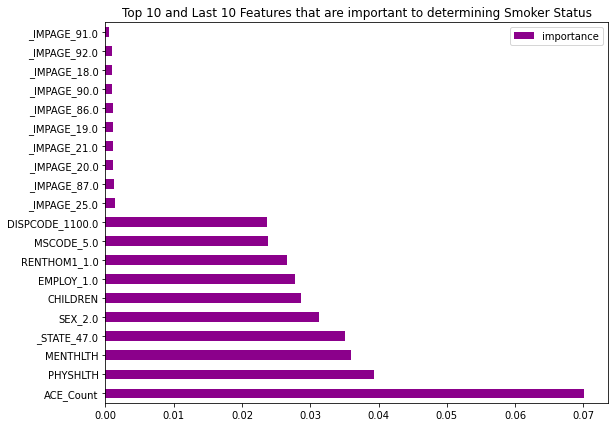

In [106]:
top_bottom(smoker_all, color='darkmagenta')
plt.title('Top 10 and Last 10 Features that are important to determining Smoker Status');

In [107]:
X_ace = X_num[['ACE_Count']]

In [108]:
X_ace.head()

,ACE_Count
0,0.0
1,3.0
2,0.0
3,0.0
4,0.0


In [109]:
# put in EDA notebook and create visualization(s)
X_ace.value_counts(normalize=True)

ACE_Count
0.0          0.430284
1.0          0.162409
2.0          0.113283
3.0          0.070818
4.0          0.053711
5.0          0.039803
6.0          0.031526
7.0          0.025511
8.0          0.020450
9.0          0.014359
10.0         0.010659
11.0         0.007860
12.0         0.005589
13.0         0.004475
14.0         0.003734
15.0         0.002986
16.0         0.001565
17.0         0.000978
dtype: float64

In [110]:
# creating the 4 y's for ACE count only
y_tobacco_ace = brfss_total['USENOW3']
y_activity_ace = brfss_total['QLACTLM2']
y_health_ace = brfss_total['_RFHLTH']
y_smoker_ace = brfss_total['_SMOKER3']

In [111]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X1, y_tobacco_ace = sm.fit_resample(X_ace, y_tobacco_ace)

sm2 = SMOTE(random_state=151)
X2, y_activity_ace = sm2.fit_resample(X_ace, y_activity_ace)

sm3 = SMOTE(random_state=151)
X3, y_health_ace = sm3.fit_resample(X_ace, y_health_ace)

sm4 = SMOTE(random_state=151)
X4, y_smoker_ace = sm4.fit_resample(X_ace, y_smoker_ace)

In [112]:
X1.shape

(454496, 1)

In [113]:
# creating training and testing sets for all y's 
X_train_ace, X_test_ace, y_train_tobacco_ace, y_test_tobacco_ace = train_test_split(X1, y_tobacco_ace, random_state = 151, stratify=y_tobacco_ace)
X_train_ace2, X_test_ace2, y_train_activity_ace, y_test_activity_ace = train_test_split(X2, y_activity_ace, random_state = 151, stratify=y_activity_ace)
X_train_ace3, X_test_ace3, y_train_health_ace, y_test_health_ace = train_test_split(X3, y_health_ace, random_state = 151, stratify=y_health_ace)
X_train_ace4, X_test_ace4, y_train_smoker_ace, y_test_smoker_ace = train_test_split(X4, y_smoker_ace, random_state = 151, stratify=y_smoker_ace)

In [114]:
ace_tobacco = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 3, n_estimators = 20)
ace_tobacco.fit(X_train_ace, y_train_tobacco_ace)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
ace_activity = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100)
ace_activity.fit(X_train_ace2, y_train_activity_ace)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
ace_health = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500)
ace_health.fit(X_train_ace3, y_train_health_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [117]:
ace_smoker = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300)
ace_smoker.fit(X_train_ace4, y_train_smoker_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [118]:
tobacco_ace_preds = ace_tobacco.predict(X_test_ace)
activity_ace_preds = ace_activity.predict(X_test_ace2)
health_ace_preds = ace_health.predict(X_test_ace3)
smoker_ace_preds = ace_smoker.predict(X_test_ace4)

tobacco_ace_prec = precision_score(y_test_tobacco_ace, tobacco_ace_preds, average='micro')
activity_ace_prec = precision_score(y_test_activity_ace, activity_ace_preds, average='micro')
health_ace_prec = precision_score(y_test_health_ace, health_ace_preds, average='micro')
smoker_ace_prec = precision_score(y_test_smoker_ace, smoker_ace_preds, average='micro')

In [119]:
print(f' training accuracy for tobacco: {ace_tobacco.score(X_train_ace, y_train_tobacco_ace)}')
print(f' training accuracy for activity: {ace_activity.score(X_train_ace2, y_train_activity_ace)}')
print(f' training accuracy for health: {ace_health.score(X_train_ace3, y_train_health_ace)}')
print(f' training accuracy for smoker: {ace_smoker.score(X_train_ace4, y_train_smoker_ace)}')

 training accuracy for tobacco: 0.39541822150249945
 training accuracy for activity: 0.4178955717670142
 training accuracy for health: 0.37861604284030476
 training accuracy for smoker: 0.27469196209165675


In [120]:
print(f' testing accuracy for tobacco: {ace_tobacco.score(X_test_ace, y_test_tobacco_ace)}')
print(f' testing accuracy for activity: {ace_activity.score(X_test_ace2, y_test_activity_ace)}')
print(f' testing accuracy for health: {ace_health.score(X_test_ace3, y_test_health_ace)}')
print(f' testing accuracy for smoker: {ace_smoker.score(X_test_ace4, y_test_smoker_ace)}')

 testing accuracy for tobacco: 0.3915105963528832
 testing accuracy for activity: 0.41995021838162777
 testing accuracy for health: 0.3822059499116005
 testing accuracy for smoker: 0.2738968189765403


In [121]:
print(f'Precision for tobacco: {tobacco_ace_prec}')
print(f'Precision for activity: {activity_ace_prec}')
print(f'Precision for health: {health_ace_prec}')
print(f'Precision for smoker: {smoker_ace_prec}')

Precision for tobacco: 0.3915105963528832
Precision for activity: 0.41995021838162777
Precision for health: 0.3822059499116005
Precision for smoker: 0.2738968189765403




---




**Since we're only looking at one feature, the amount of ACEs someone had, to predict the y's, I believe logistic regression to be the best course of action when modeling. It is simple and easy to understand, something that is an asset when talking about such a sensitive topic. Also, the accuracy and precision for each y is comprable to those for the ensemble models above, differing the most for smokeless tobacco usage.**

---



In [122]:
ace_tobacco_lr = LogisticRegression(C=0.01)
ace_tobacco_lr.fit(X_train_ace, y_train_tobacco_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [123]:
ace_activity_lr = LogisticRegression(C=0.01)
ace_activity_lr.fit(X_train_ace2, y_train_activity_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [124]:
ace_health_lr = LogisticRegression(C=0.01)
ace_health_lr.fit(X_train_ace3, y_train_health_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
ace_smoker_lr = LogisticRegression(C=0.01)
ace_smoker_lr.fit(X_train_ace4, y_train_smoker_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
tobacco_ace_preds_lr = ace_tobacco_lr.predict(X_test_ace)
activity_ace_preds_lr = ace_activity_lr.predict(X_test_ace2)
health_ace_preds_lr = ace_health_lr.predict(X_test_ace3)
smoker_ace_preds_lr = ace_smoker_lr.predict(X_test_ace4)

tobacco_ace_prec_lr = precision_score(y_test_tobacco_ace, tobacco_ace_preds_lr, average='micro')
activity_ace_prec_lr = precision_score(y_test_activity_ace, activity_ace_preds_lr, average='micro')
health_ace_prec_lr = precision_score(y_test_health_ace, health_ace_preds_lr, average='micro')
smoker_ace_prec_lr = precision_score(y_test_smoker_ace, smoker_ace_preds_lr, average='micro')

print(f'Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: {ace_smoker_lr.score(X_train_ace, y_train_tobacco_ace)}')
print(f'Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: {ace_smoker_lr.score(X_test_ace, y_test_tobacco_ace)}')
print(f'Logistic Regression precision for smokeless tobacco usage w/ACE grouped: {tobacco_ace_prec_lr}')

print(f'Logistic Regression training accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_train_ace2, y_train_activity_ace)}')
print(f'Logistic Regression testing accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_test_ace2, y_test_activity_ace)}')
print(f'Logistic Regression precision for activity limitations w/ACE grouped: {activity_ace_prec_lr}')

print(f'Logistic Regression training accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_train_ace3, y_train_health_ace)}')
print(f'Logistic Regression testing accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_test_ace3, y_test_health_ace)}')
print(f'Logistic Regression precision for self-reported health w/ACE grouped: {health_ace_prec_lr}')

print(f'Logistic Regression training accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_train_ace4, y_train_smoker_ace)}')
print(f'Logistic Regression testing accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_test_ace4, y_test_smoker_ace)}')
print(f'Logistic Regression precision for smoker w/ACE grouped: {smoker_ace_prec_lr}')

Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: 0.3366307587598864
Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: 0.33696226149405056
Logistic Regression precision for smokeless tobacco usage w/ACE grouped: 0.3732046046609871
Logistic Regression training accuracy for activity limitations w/ACE grouped: 0.39769038897064196
Logistic Regression testing accuracy for activity limitations w/ACE grouped: 0.4002880445842922
Logistic Regression precision for activity limitations w/ACE grouped: 0.4002880445842922
Logistic Regression training accuracy for self-reported health w/ACE grouped: 0.3632562715199213
Logistic Regression testing accuracy for self-reported health w/ACE grouped: 0.3658764077791544
Logistic Regression precision for self-reported health w/ACE grouped: 0.3658764077791544
Logistic Regression training accuracy for smoker status w/ACE grouped: 0.2615223357384864
Logistic Regression testing accuracy for smoker statu

In [188]:
# getting the coefficient for each tobacco class
coef_dk_tobacco = ace_tobacco_lr.coef_[0]
coef_everyday_tobacco = ace_tobacco_lr.coef_[1]
coef_somedays_tobacco = ace_tobacco_lr.coef_[2]
coef_notatall = ace_tobacco_lr.coef_[3]

# converting the log odds for each tobacco class into regular odds for interpretation
odds_dk_tobacco = np.exp(coef_dk_tobacco)
odds_everyday_tobacco = np.exp(coef_everyday_tobacco)
odds_somedays_tobacco = np.exp(coef_somedays_tobacco)
odds_notatall = np.exp(coef_notatall)

# putting converted odds into a dataframe
tobacco_coefs = pd.DataFrame([odds_dk_tobacco, odds_everyday_tobacco, odds_somedays_tobacco, odds_notatall], 
             index=['do not know', 'every day', 'some days', 'not at all'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
tobacco_coefs

,coef
some days,1.231454
every day,1.203343
not at all,1.184388
do not know,0.569769


In [187]:
# getting the coefficient for each smoker class
coef_dk_activity = ace_activity_lr.coef_[0]
coef_yes_activity = ace_activity_lr.coef_[1]
coef_no_activity = ace_activity_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_activity = np.exp(coef_dk_activity)
odds_yes_activity = np.exp(coef_yes_activity)
odds_no_activity = np.exp(coef_no_activity)

# putting converted odds into a dataframe
activity_coefs = pd.DataFrame([odds_dk_activity, odds_yes_activity, odds_no_activity], 
             index=['do not know', 'yes', 'no'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
activity_coefs

,coef
yes,1.079038
no,0.977438
do not know,0.948143


In [186]:
# getting the coefficient for each smoker class
coef_dk_health = ace_health_lr.coef_[0]
coef_good_better_health = ace_health_lr.coef_[1]
coef_fair_poor_health = ace_health_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_health = np.exp(coef_dk_health)
odds_good_better_health = np.exp(coef_good_better_health)
odds_fair_poor_health = np.exp(coef_fair_poor_health)

# putting converted odds into a dataframe
health_coefs = pd.DataFrame([odds_dk_health, odds_good_better_health, odds_fair_poor_health], 
             index=['do not know', 'Good or Better', 'Fair or Poor'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
health_coefs

,coef
Fair or Poor,1.052787
do not know,0.976013
Good or Better,0.973204


In [185]:
# got information about converting odds from https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

# getting the coefficient for each smoker class
coef_dk = ace_smoker_lr.coef_[0]
coef_everyday = ace_smoker_lr.coef_[1]
coef_somedays = ace_smoker_lr.coef_[2]
coef_former = ace_smoker_lr.coef_[3]
coef_never = ace_smoker_lr.coef_[4]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk = np.exp(coef_dk)
odds_everyday = np.exp(coef_everyday)
odds_somedays = np.exp(coef_somedays)
odds_former = np.exp(coef_former)
odds_never = np.exp(coef_never)

# putting converted odds into a dataframe
smoker_coefs = pd.DataFrame([odds_dk, odds_everyday, odds_somedays, odds_former, odds_never], 
             index=['do not know', 'every day', 'some days', 'former', 'never'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
smoker_coefs

,coef
every day,1.117562
some days,1.087477
former,1.011841
never,0.946563
do not know,0.859105


In [197]:
def coef_interpret(data):

  '''Function to interpret multiclass logistic regression coefficients. 
  Coefficient interpretation guidance came from http://www.columbia.edu/~so33/SusDev/Lecture_10.pdf

  data: a dataframe that only includes y classes, as an index, on only coefficients for each class

  '''
  for response, row in zip(data.index, data['coef']):
    if row > 1:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class INCREASES by {(row - 1)*100}% when all other variables are held constant.')
    else:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class DECREASES by {(1-row)*100}% when all other variables are held constant.')
  return

In [198]:
print(f'Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?')
coef_interpret(tobacco_coefs)

Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 23.145436492076854% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 20.33427229310547% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the not at all class INCREASES by 18.438768561235296% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 43.02314698393508% when all other variables are held constant.


In [194]:
print(f'Are you limited in any way in any activities because of physical, mental, or emotional problems?')
coef_interpret(activity_coefs)

Are you limited in any way in any activities because of physical, mental, or emotional problems?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the yes class INCREASES by 7.9037871605081245% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the no class DECREASES by 2.2561583286188513% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 5.185685808892371% when all other variables are held constant.


In [195]:
print(f'Adults with good or better health vs. fair or poor health')
coef_interpret(health_coefs)

Adults with good or better health vs. fair or poor health
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Fair or Poor class INCREASES by 5.278700709805695% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 2.398728408467765% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Good or Better class DECREASES by 2.6795725798957504% when all other variables are held constant.


In [196]:
print(f'Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers')
coef_interpret(smoker_coefs)

Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 11.756180702293495% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 8.74772831398758% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the former class INCREASES by 1.1841081927644437% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the never class DECREASES by 5.343691996171318% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 14.089472469805052% when all other 